In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range, propagation_ew
from abtem.waves import PlaneWave
from Column_matching import (
    Bessel_transform,
    propagation_Bessel
)
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)
from Defocus_circle import generate_continious_phase
from sklearn.linear_model import LinearRegression

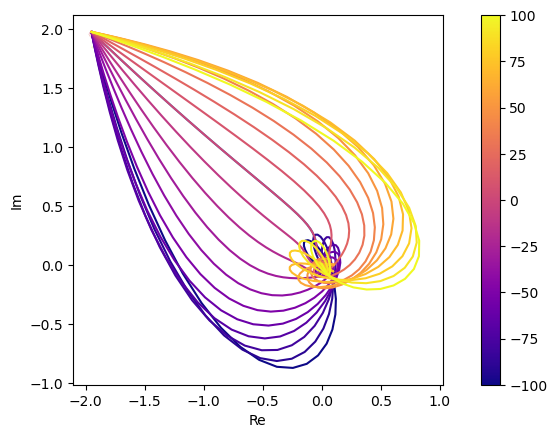

In [7]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 2
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
#Generate isolated structure
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                       x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
x = np.arange(0, m, 1) - x0; y = np.arange(0, n, 1) - y0
X, Y = np.meshgrid(x, y); R = np.sqrt(X**2 + Y**2)*sampling
plt.plot(np.real(results), np.imag(results))
distance_range = np.arange(-100, 110, 10)
cmap = plt.get_cmap("plasma")
coeff_rec = []
for distance in distance_range:
    #ew_prop_all = propagation_ew(exitwave_all, distance, sampling, energy)
    #m, n = exitwave_all.shape
    #ew_prop = ew_prop_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
    #                       (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    #m, n = ew_prop.shape
    ew_prop = propagation_ew(exitwave, distance, sampling, energy)
    results_prop, components_prop = Bessel_transform(ew_prop, sampling, gmin+cut_factor, gmax, length, 
                                       x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    #results_prop, components_prop = propagation_Bessel(results, distance, gmin+cut_factor, gmax, length, sampling, energy, 
    #                                                exitwave.shape, x0, y0)
    fitted_prop = Gaussian_fitting(results_prop, krange, [0.01, 1])
    coeff_prop = np.array(list(fitted_prop.best_values.values()))
    coeff_rec.append(coeff_prop)
    plt.plot(np.real(results_prop), np.imag(results_prop), color=cmap((distance+100)/200))
coeff_rec = np.array(coeff_rec)
ew_total = (coeff_rec[:,0]+coeff_rec[:,-2]) + 1j*(coeff_rec[:,1]+coeff_rec[:,-1])
s=plt.scatter(np.real(ew_total), np.imag(ew_total), c=distance_range, cmap='plasma', s=0.01)
plt.colorbar(s)
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

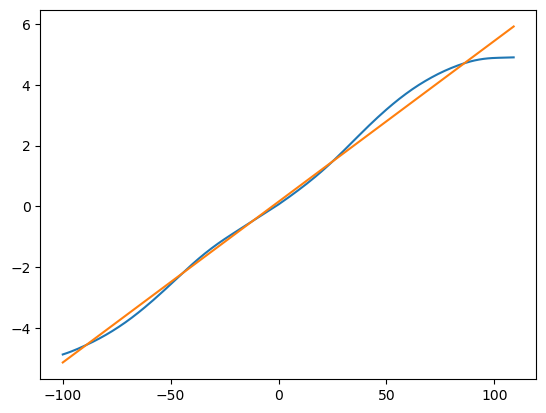

In [59]:
plt.plot(distance_range.reshape(-1, 1), coeff_rec[:,3])
res = LinearRegression().fit(distance_range.reshape(-1, 1), coeff_rec[:,3])
plt.plot(distance_range, res.predict(distance_range.reshape(-1, 1)))
plt.show()

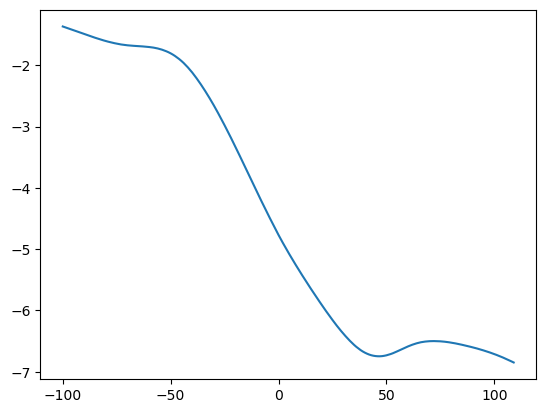

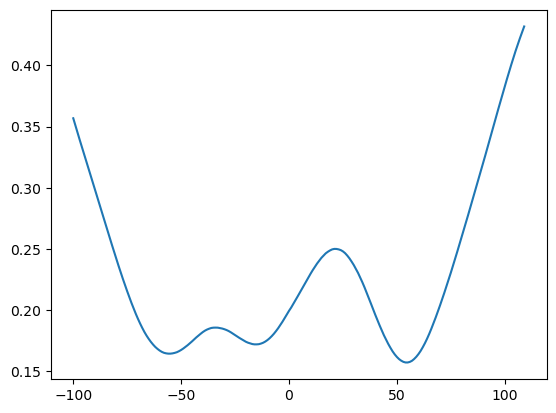

In [60]:
bg_complex = coeff_rec[:,-2] + 1j * coeff_rec[:,-1]
plt.plot(distance_range, generate_continious_phase(bg_complex))
plt.show()
plt.plot(distance_range, np.abs(bg_complex))
plt.show()

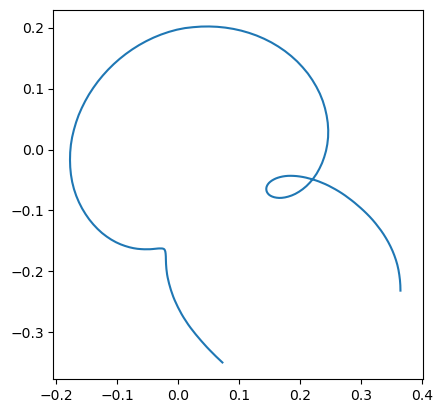

In [61]:
plt.plot(np.real(bg_complex), np.imag(bg_complex))
plt.axis("square")
plt.show()

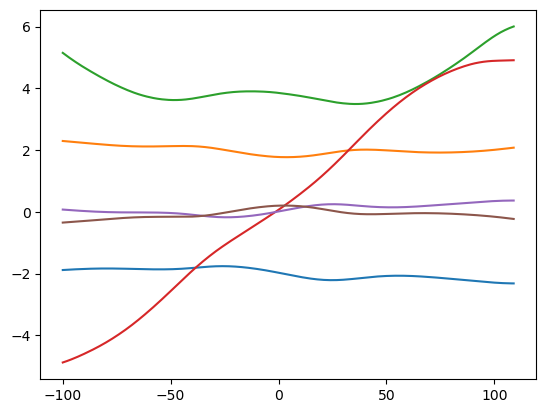

In [62]:
for label in range(6):
    plt.plot(distance_range, coeff_rec[:,label])
plt.show()

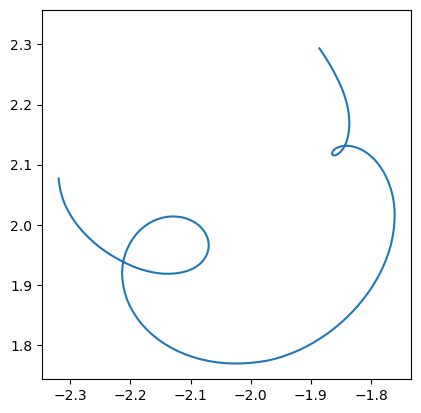

In [63]:
plt.plot(coeff_rec[:,0], coeff_rec[:,1])
plt.axis("square")
plt.show()

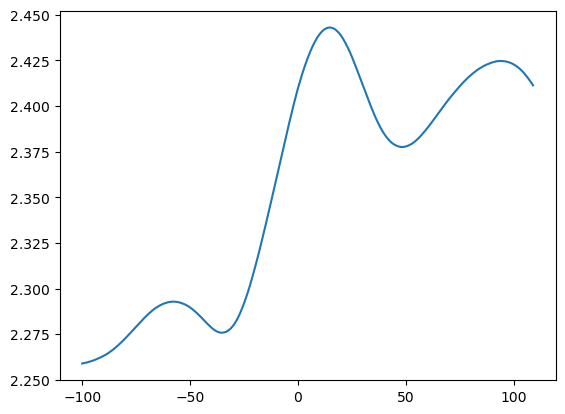

In [65]:
peak_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
plt.plot(distance_range, np.angle(peak_complex))
#plt.axis("square")
plt.show()